# Chart 3

<img src="../charts/smwHN-despite-wide-uncertainty-conflict-is-among-the-deadliest-of-the-century.png" alt="Chart as shown on original article]" width="700"/>

The source for this is the [Uppsala Conflict Data Program](https://ucdp.uu.se/), which has a standardized definition of conflict and a methodology for death counting. They are doing that for worldwide conflicts since 1975.

Their definition for a state-based conflict is as follows:

`A contested incompatibility that concerns
government and/or territory where the use of armed force between two parties, of which at least
one is the government of a state, results in at least 25 battle-related deaths in a calendar year.”`

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)

#### Disaggregated events
This dataset shows the number of deaths at each date for any given _event of violence_. UCDP defines an event of violence as follows:

`An incident where armed force was used by an organized actor against
another organized actor, or against civilians, resulting in at least 1 direct death at a specific location
and a specific date.`


Please notice that not all events of violence happen during conflicts, as they also have to meet the conflict definition stated before.

We'll now read the file that contains all the deaths up to 2023, which already underwent quality control.

In [2]:
df = pd.read_csv("../data/UCDP/ged241-csv.zip")

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_80623/3661687351.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/UCDP/ged241-csv.zip")


For example, below is the low, best and high estimates of deaths in the Ukraine war (notice that their conflict definition starts with the first clashes, in 2014).

In [3]:
df[df.conflict_name=='Russia - Ukraine'][['low', 'best', 'high']].sum()

low     114922
best    162434
high    307677
dtype: int64

The following dataset has all 'likely events' for 2024. They didn't went thorugh the same checks as the pre-2024 data, but the documentation claims that it's "very likely" that they'll be included.

In [4]:
df_2024 = pd.read_csv("../data/UCDP/GEDEvent_v24_01_24_12.csv")

In [5]:
# Estimates for 2024 in Ukraine
df_2024[df_2024.conflict_name=='Russia - Ukraine'][['low', 'best', 'high']].sum()

low      59017
best     72777
high    112048
dtype: int64

We can concatenate both to have an estimate of total deaths – although I wouldn't use it for any kind of time comparison.

In [6]:
df = pd.concat([df, df_2024])

In [7]:
df[df.conflict_name=='Russia - Ukraine'][['low', 'best', 'high']].sum()

low     173939
best    235211
high    419725
dtype: int64

In [36]:
df[df.conflict_name=='Russia - Ukraine'].groupby('year')[['low', 'best', 'high']].sum()

,low,best,high
year,,,
2014,3,3,3
2016,2,2,2
2022,64013,91724,166142
2023,50904,70705,141530
2024,59017,72777,112048


Below is a list of the deadliest conflicts since the beginning of data collection. 

Notice that when "government" is on the name, usually it means a multi-sided struggle for the control of the state, instead of a war between clearly defined governments or factions. For example, [Syria: Government](https://ucdp.uu.se/conflict/299) refers to clashes between the Assad regime and other groups that wanted to take over the state. Meanwhile, [Syria: Islamic State](https://ucdp.uu.se/conflict/13604) refers to the specific battles between the Syrian Defense Forces and its coallition against IS.

Details about each conflict definition can always be found at the UCDP website, following the pattern `https://ucdp.uu.se/conflict/{conflict_new_id}`

In [8]:
df.groupby(['conflict_name', 'conflict_new_id'])\
[['low', 'best', 'high']].sum()\
.sort_values(by='best', ascending=False).head(30)

,,low,best,high
conflict_name,conflict_new_id,,,
Government of Rwanda - Civilians,472,376305,794306,1657058
Ethiopia: Government,267,348837,349516,352679
Syria: Government,299,276971,287298,304025
Afghanistan: Government,333,265156,286124,357441
Russia - Ukraine,13243,173939,235211,419725
Eritrea - Ethiopia,409,97435,98217,99372
Iraq: Government,259,66285,69360,80806
Yemen (North Yemen): Government,230,54984,61175,91524
Sri Lanka (Ceylon): Eelam,352,60644,60816,74185


However, remember that we are looking at `state based conflicts`, and not all events of violence. To account for that, we will have to remove data for conflicts such as 'Jalisco Cartel New Generation - Sinaloa Cartel', as they are not pertinent to this analysis.

Let's keep only the violence events that happened during the state-based conflicts listed here, in the years listed, and add the 2024 deaths if they exceed 25.

In [9]:
sbc = df[
    # Is state based
    (df.type_of_violence==1)
    # Is active – that is, does the conflict meet the minimum threshold of 25 deaths a year?
    & (df.active_year)
    # Is recent
    & (df.year >= 2001)
]

Here we show the death esitmates for the 10 state-based conflicts that had the most deaths since 2001.

In [10]:
rank = sbc.groupby(['conflict_name', 'conflict_new_id'])[['low', 'best', 'high']].sum()\
    .sort_values(by='best', ascending=False).head(10).reset_index()

display(rank)

,conflict_name,conflict_new_id,low,best,high
0,Ethiopia: Government,267,306928,307607,309690
1,Syria: Government,299,276970,287297,304024
2,Russia - Ukraine,13243,173934,235206,419720
3,Afghanistan: Government,333,214085,227979,272436
4,Iraq: Government,259,65265,68336,77816
5,Yemen (North Yemen): Government,230,54966,61126,91449
6,Israel: Palestine,234,52120,52625,53460
7,Syria: Islamic State,13604,48397,50010,53634
8,Somalia: Government,337,32956,36324,49027
9,Pakistan: Government,404,29864,31764,34501


In [11]:
# Save for usage in Datawrapper
rank.to_csv("../output/top-10-conflicts.csv", index=False)

#### Conflict info
In this secondary dataset, we have detailed information about each one of the **state based conflicts**, like the sides involved. Details about each actor (that is, each involved party) can be accessed using their id on UCDPs website: `https://ucdp.uu.se/actor/{side_id}`

In [12]:
# Reading data
conflicts = pd.read_csv("../data/UCDP/ucdp-prio-acd-241-csv.zip")

In [13]:
# Looking at the data
conflicts.head()

,conflict_id,location,side_a,side_a_id,side_a_2nd,side_b,side_b_id,side_b_2nd,incompatibility,territory_name,...,ep_end,ep_end_date,ep_end_prec,gwno_a,gwno_a_2nd,gwno_b,gwno_b_2nd,gwno_loc,region,version
0,11342,India,Government of India,141,NaN,GNLA,1163,NaN,1,Garoland,...,1,2012-12-21,NaN,750,NaN,NaN,NaN,750,3,24.1
1,11342,India,Government of India,141,NaN,GNLA,1163,NaN,1,Garoland,...,1,2014-11-27,NaN,750,NaN,NaN,NaN,750,3,24.1
2,11343,"Egypt, Israel",Government of Egypt,117,NaN,Government of Israel,121,NaN,1,Suez/Sinai,...,1,1967-06-10,NaN,651,NaN,666,NaN,"651, 666",2,24.1
3,11343,"Egypt, Israel",Government of Egypt,117,NaN,Government of Israel,121,NaN,1,Suez/Sinai,...,0,NaN,NaN,651,NaN,666,NaN,"651, 666",2,24.1
4,11343,"Egypt, Israel",Government of Egypt,117,NaN,Government of Israel,121,NaN,1,Suez/Sinai,...,1,1970-08-07,NaN,651,NaN,666,NaN,"651, 666",2,24.1


In [14]:
# All columns
conflicts.columns

Index(['conflict_id', 'location', 'side_a', 'side_a_id', 'side_a_2nd',
       'side_b', 'side_b_id', 'side_b_2nd', 'incompatibility',
       'territory_name', 'year', 'intensity_level', 'cumulative_intensity',
       'type_of_conflict', 'start_date', 'start_prec', 'start_date2',
       'start_prec2', 'ep_end', 'ep_end_date', 'ep_end_prec', 'gwno_a',
       'gwno_a_2nd', 'gwno_b', 'gwno_b_2nd', 'gwno_loc', 'region', 'version'],
      dtype='object')

Below is a list of all the countries in the rank we created above. We can check if they had 25 or more deaths in 2024, according to the best estimate. If this is the case, we'll mark them as ongoing in the chart.

In [15]:
sbc_yearly = sbc[sbc.conflict_new_id.isin(
    rank.conflict_new_id
)].groupby(['conflict_name', 'conflict_new_id', 'year'])[['best']].sum()

display(sbc_yearly)

best
conflict_name                   conflict_new_id year        
Afghanistan: Government         333             2001    2328
                                                2002      30
                                                2003     660
                                                2004     711
                                                2005    1628
                                                2006    4734
                                                2007    6848
                                                2008    5655
                                                2009    6390
                                                2010    7038
                                                2011    7423
                                                2012    7730
                                                2013    8048
                                                2014   12351
                                                2015   16581
                                                2016   15775
                                                2017   16179
                                                2018   22837
                                                2019   28828
                                                2020   20159
                                                2021   35329
                                                2022     617
                                                2023      74
                                                2024      26
Ethiopia: Government            267             2020   20888
                                                2021  124266
                                                2022  162453
Iraq: Government                259             2004    4094
                                                2005    2608
                                                2006    3923
                                                2007    2212
                                                2008    2112
                                                2009    1036
                                                2010     989
                                                2011     864
                                                2012     565
                                                2013    1870
                                                2014   13797
                                                2015   10981
                                                2016    9775
                                                2017   10012
                                                2018     866
                                                2019     498
                                                2020     674
                                                2021     707
                                                2022     338
                                                2023     203
                                                2024     212
Israel: Palestine               234             2001     244
                                                2002     613
                                                2003     308
                                                2004     386
                                                2005     123
                                                2006     348
                                                2007     276
                                                2008     668
                                                2009     696
                                                2010      27
                                                2011      78
                                                2012     235
                                                2014    2378
                                                2018      53
                                                2019      50
                                                2021     269
                              

Finally, we'll go through the conflicts dataset and get the initial year for those. Notice that many of them got 'cold' for many years, with cycles of realtive peace and violence.

In [16]:
# Gets ranges for all conflicts (up to 2023)
ranges = conflicts[conflicts.conflict_id.isin(rank.conflict_new_id)]\
    .groupby('conflict_id')\
    .apply(lambda group: [group.year.min(), group.year.max()])


In [17]:
# Converts to frame
ranges = ranges.to_frame().rename(columns={0:'year_range'}).reset_index()

In [18]:
# Merge with the ranked conflicts to check their start and end dates
rank = rank.merge(ranges, left_on='conflict_new_id', right_on='conflict_id')
display(rank)

,conflict_name,conflict_new_id,low,best,high,conflict_id,year_range
0,Ethiopia: Government,267,306928,307607,309690,267,"[1960, 2022]"
1,Syria: Government,299,276970,287297,304024,299,"[1966, 2023]"
2,Russia - Ukraine,13243,173934,235206,419720,13243,"[2022, 2023]"
3,Afghanistan: Government,333,214085,227979,272436,333,"[1978, 2023]"
4,Iraq: Government,259,65265,68336,77816,259,"[1958, 2023]"
5,Yemen (North Yemen): Government,230,54966,61126,91449,230,"[1948, 2023]"
6,Israel: Palestine,234,52120,52625,53460,234,"[1949, 2023]"
7,Syria: Islamic State,13604,48397,50010,53634,13604,"[2013, 2023]"
8,Somalia: Government,337,32956,36324,49027,337,"[1982, 2023]"
9,Pakistan: Government,404,29864,31764,34501,404,"[1990, 2023]"


In [19]:
# Go through them to check if 2024 had 25+ deaths, update id that's the case.
# Those will be treated as ongoing conflicts.
for index, row in rank.iterrows():
    
    # Gets yearly deaths for conflict
    subset = sbc_yearly.loc[row.conflict_name, row.conflict_new_id]
    # If 2024 among years
    if 2024 in subset.index:
        # Get deaths
        deaths_2024 = subset.loc[2024].best
        # If they meet threshold, replace
        if deaths_2024 >= 25:
            rank.loc[index, 'year_range'][1] = 2024 
    
    


In [20]:
# Finally, this is the data that will be displayed at the DataWrapper chart
rank

,conflict_name,conflict_new_id,low,best,high,conflict_id,year_range
0,Ethiopia: Government,267,306928,307607,309690,267,"[1960, 2022]"
1,Syria: Government,299,276970,287297,304024,299,"[1966, 2024]"
2,Russia - Ukraine,13243,173934,235206,419720,13243,"[2022, 2024]"
3,Afghanistan: Government,333,214085,227979,272436,333,"[1978, 2024]"
4,Iraq: Government,259,65265,68336,77816,259,"[1958, 2024]"
5,Yemen (North Yemen): Government,230,54966,61126,91449,230,"[1948, 2024]"
6,Israel: Palestine,234,52120,52625,53460,234,"[1949, 2024]"
7,Syria: Islamic State,13604,48397,50010,53634,13604,"[2013, 2024]"
8,Somalia: Government,337,32956,36324,49027,337,"[1982, 2024]"
9,Pakistan: Government,404,29864,31764,34501,404,"[1990, 2024]"


In [21]:
# Let's also save a version of the chart with yearly aggregates, looking only at best estimates
sbc_yearly = sbc_yearly.reset_index().merge(rank[['conflict_new_id', 'year_range']]) # add ranges

In [22]:
sbc_yearly_dw = sbc_yearly.pivot(index='year', columns='conflict_name', values='best').fillna(0).reset_index()
sbc_yearly_dw.to_csv("../output/conflicts-yearly-deaths.csv", index=False)

In [23]:
#### Chart with deaths over time for Russia-Ukraine war only

In [24]:
# Set datetime of event
df['datetime'] = pd.to_datetime(df.date_end)

In [25]:
# Set datetime as index
df = df.set_index('datetime')

In [26]:
# Keeps only UKR X RUS war
ukru = df[df.conflict_new_id==13243]

In [27]:
# Only deaths after start of full scale invasion
ukru = ukru["2022-02-24":]

<Axes: xlabel='datetime'>

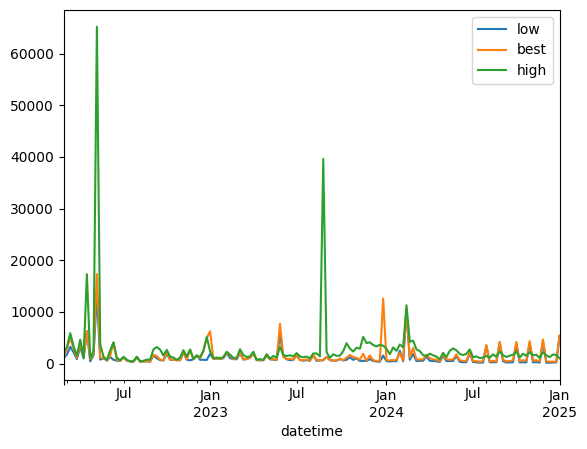

In [28]:
# Notice there are some inconsitencies – some points in time when the best estimate is apparently higher
# than the high estimate, for example
ukru.resample('W')[['low', 'best', 'high']].sum().plot()

In [29]:
# While we don't get a reply from UCDP, let's "fix"
# the apparent inconsistencies by sorting the values in the low-mid-high order
# at the individual event level
for index, row in ukru.iterrows():
        
        ordered = sorted([row.low, row.best, row.high])
        ukru.loc[index, 'low'] = ordered[0]
        ukru.loc[index, 'best'] = ordered[1]
        ukru.loc[index, 'high'] = ordered[2]

<Axes: xlabel='datetime'>

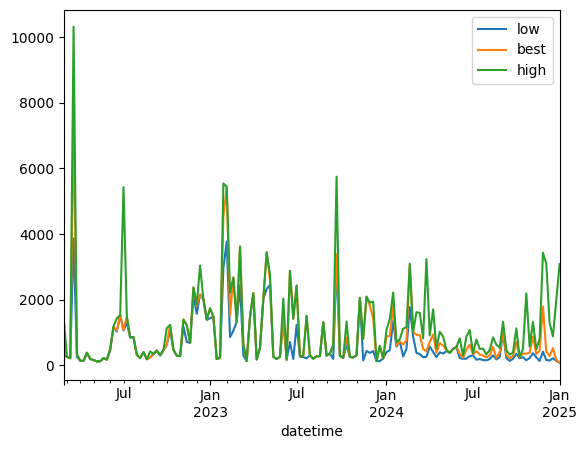

In [30]:
# Now the estimates converge
ukru.resample('W')[['low', 'best', 'high']].sum().plot()

In [33]:
# Save to csv
ukru.resample('M')[['low', 'best', 'high']].sum().to_csv("../output/montly-deaths-uncertainty.csv")

In [ ]:
# Events with highest diff
ukru['diff'] = ukru['high'] - ukru['low']

In [35]:
ukru.resample('M')[['low', 'best', 'high']].sum().sum()

low      95421
best    134520
high    176998
dtype: int64